In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.lite as tflite
from collections import Counter
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    AveragePooling1D,
    AveragePooling2D,
    Concatenate,
    Conv1D,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Reshape,
    SeparableConv1D,
    SeparableConv2D,
)
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import plot_model
from tensorflow_model_optimization.quantization.keras import quantize_model
from tqdm.notebook import tqdm

from sklearn.utils import class_weight


print(f"Tensorflow v{tf.__version__}")

Tensorflow v2.12.0


In [2]:
EPOCHS = 100
BATCH_SIZE = 256

In [3]:
train_dataset = np.load("train.npz")
val_dataset = np.load("val.npz")
test_dataset = np.load("test.npz")

In [4]:
train_x = train_dataset["x"]
train_y = train_dataset["y"]

val_x = val_dataset["x"]
val_y = val_dataset["y"]

test_x = test_dataset["x"]
test_y = test_dataset["y"]

In [5]:
weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(train_y), y=train_y
)
class_weights = dict(enumerate(weights))

{0: 1.8162982009931339, 1: 0.46414448388578994, 2: 3.390657066332742}


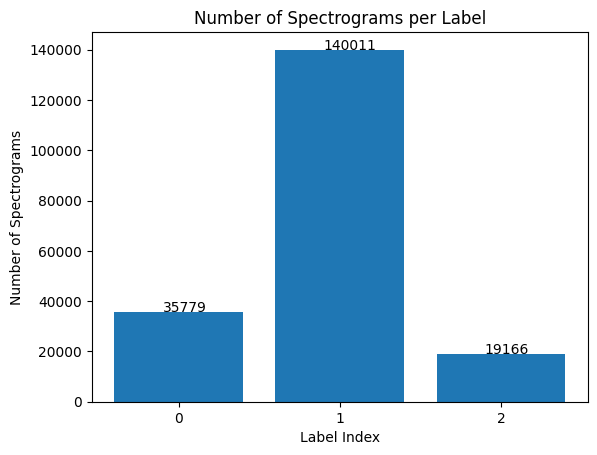

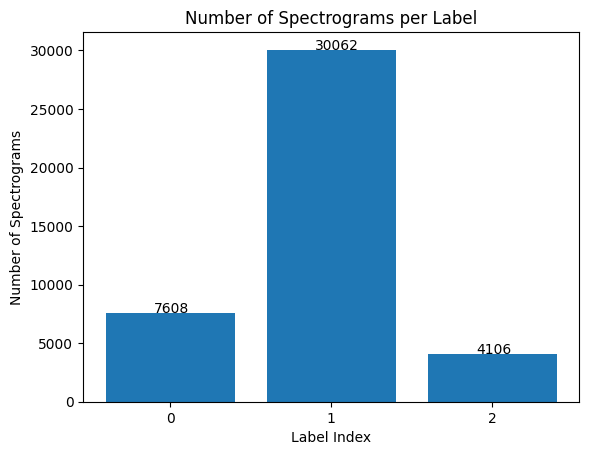

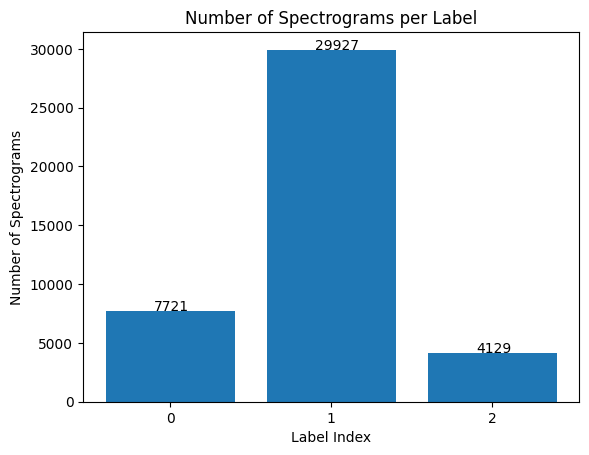

In [17]:
def plot_histogram(data):
    label_counts = Counter(data)
    bars = plt.bar(label_counts.keys(), label_counts.values())

    plt.title("Number of Spectrograms per Label")
    plt.xlabel("Label Index")
    plt.ylabel("Number of Spectrograms")
    plt.xticks(list(label_counts.keys()))

    for bar, count in zip(bars, label_counts.values()):
        plt.text(
            bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, str(count)
        )

    plt.show()


plot_histogram(train_y)
plot_histogram(val_y)
plot_histogram(test_y)

In [8]:
train_ds = Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(10000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = Dataset.from_tensor_slices((val_x, val_y))
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(AUTOTUNE)

test_ds = Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(AUTOTUNE)

In [10]:
INPUT_SHAPE = train_x[0].shape
print(INPUT_SHAPE)

earlystop = EarlyStopping(monitor="val_loss", patience=5)

(99, 43, 1)


In [11]:
inputs = Input(shape=[99, 43, 1])
reshaped = Reshape((99, 43))(inputs)

conv1D = Conv1D(8, 3, activation="relu", padding="same")(reshaped)
conv1D = SeparableConv1D(8, 3, activation="relu", dilation_rate=2, padding="same")(
    conv1D
)
conv1D = SeparableConv1D(8, 3, activation="relu", dilation_rate=4, padding="same")(
    conv1D
)
conv1D = AveragePooling1D(5, padding="same")(conv1D)

conv1D = Flatten()(conv1D)
conv1D = Dense(16, activation="relu")(conv1D)
conv1D = Dropout(0.2)(conv1D)

conv2D = Conv2D(8, 3, activation="relu", padding="same")(inputs)
conv2D = SeparableConv2D(8, 3, activation="relu", dilation_rate=[2, 1], padding="same")(
    conv2D
)
conv2D = SeparableConv2D(8, 3, activation="relu", dilation_rate=[4, 1], padding="same")(
    conv2D
)
conv2D = AveragePooling2D([20, 10], padding="same")(conv2D)

conv2D = Flatten()(conv2D)
conv2D = Dense(16, activation="relu")(conv2D)
conv2D = Dropout(0.2)(conv2D)

combined = Concatenate()([conv1D, conv2D])
outputs = Dense(3, name="y_pred", activation="softmax")(combined)
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0002),
    metrics=["accuracy"],
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 99, 43, 1)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 99, 43)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 99, 8)        1040        ['reshape[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 43, 8)    80          ['input_1[0][0]']                
                                                                                              

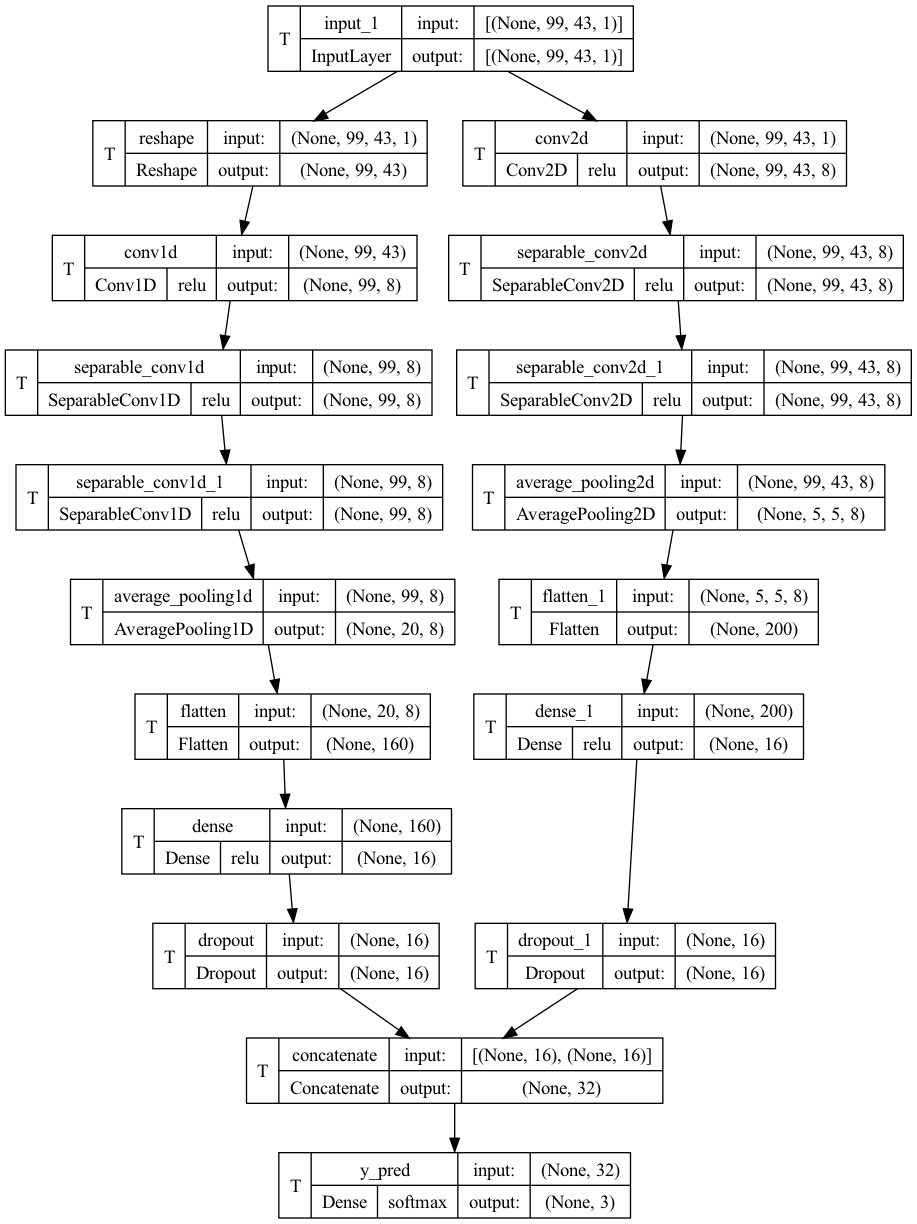

In [12]:
model.summary()

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_activations=True,
    show_trainable=True,
)

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop],
    # class_weight=class_weights
)

Epoch 1/100


2023-07-04 16:05:02.382290: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


762/762 [==============================] - 201s 263ms/step - loss: 0.3759 - accuracy: 0.8463 - val_loss: 0.0968 - val_accuracy: 0.9714
Epoch 2/100
762/762 [==============================] - 198s 260ms/step - loss: 0.1023 - accuracy: 0.9710 - val_loss: 0.0655 - val_accuracy: 0.9799
Epoch 3/100
762/762 [==============================] - 195s 256ms/step - loss: 0.0854 - accuracy: 0.9764 - val_loss: 0.0589 - val_accuracy: 0.9835
Epoch 4/100
762/762 [==============================] - 196s 257ms/step - loss: 0.0823 - accuracy: 0.9786 - val_loss: 0.0559 - val_accuracy: 0.9848
Epoch 5/100
762/762 [==============================] - 197s 258ms/step - loss: 0.0810 - accuracy: 0.9800 - val_loss: 0.0550 - val_accuracy: 0.9859
Epoch 6/100
762/762 [==============================] - 197s 258ms/step - loss: 0.0792 - accuracy: 0.9811 - val_loss: 0.0535 - val_accuracy: 0.9863
Epoch 7/100
762/762 [==============================] - 195s 256ms/step - loss: 0.0803 - accuracy: 0.9817 - val_loss: 0.0510 - val_

In [15]:
model.evaluate(test_ds)

164/164 [==============================] - 17s 104ms/step - loss: 0.0729 - accuracy: 0.9879


[0.07292363047599792, 0.9879359602928162]

In [16]:
def representative_dataset_gen():
    for data, _ in test_ds.take(100):
        yield [data]


c = tflite.TFLiteConverter.from_keras_model(model)
c.target_spec.supported_ops = [tflite.OpsSet.TFLITE_BUILTINS_INT8]
c.optimizations = [tflite.Optimize.DEFAULT]
c.representative_dataset = representative_dataset_gen
tflite_model = c.convert()

open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/hh/kv0qf0dd3cb42vpzqkt9jc940000gn/T/tmp2mtqkib_/assets


INFO:tensorflow:Assets written to: /var/folders/hh/kv0qf0dd3cb42vpzqkt9jc940000gn/T/tmp2mtqkib_/assets
/Users/pawel/repos/wake_word/model/venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-07-04 17:21:09.106396: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-04 17:21:09.106409: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


25976

In [ ]:
q_model = quantize_model(model)
q_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

In [ ]:
q_model.summary()

plot_model(
    q_model,
    to_file="q_model.png",
    show_shapes=True,
    show_layer_activations=True,
    show_trainable=True,
)

In [ ]:
q_history = q_model.fit(
    train_ds, validation_data=val_ds, epochs=5, class_weight=class_weights
)

In [ ]:
q_model.evaluate(test_ds)

In [ ]:
c = tflite.TFLiteConverter.from_keras_model(q_model)
c.optimizations = [tflite.Optimize.DEFAULT]
tflite_model = c.convert()

open("q_model.tflite", "wb").write(tflite_model)